# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('homepage_actions.csv')
data.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [4]:
data.isnull().value_counts()

timestamp  id     group  action
False      False  False  False     8188
dtype: int64

In [5]:
data.id.value_counts()

363314    2
368962    2
568156    2
267099    2
322257    2
         ..
419672    1
448358    1
761703    1
929641    1
196608    1
Name: id, Length: 6328, dtype: int64

In [61]:
data[data.id == 363314]

,timestamp,id,group,action,action_count
3751,2016-11-17 15:51:56.634476,363314,control,view,1
3752,2016-11-17 15:52:30.776850,363314,control,click,1


In [60]:
data.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [66]:
clicks = set(data[data.action=='click']['id'].unique())
views = set(data[data.action=='view']['id'].unique())
print("Number of unique clickers: {} \t Number of unique viewers: {}".format(len(clicks), len(views)))

Number of unique clickers: 1860 	 Number of unique viewers: 6328


In [63]:
print("Number of only viewers: {}".format(len(views - clicks)))

Number of only viewers: 4468


In [64]:
print("Number of only clickers: {}".format(len(clicks - views)))

Number of only clickers: 0


All clickers are viewers but not vice versa

In [10]:
data.group.value_counts()

control       4264
experiment    3924
Name: group, dtype: int64

In [14]:
control = data[data.group == 'control']
experiment = data[data.group == 'experiment']

In [15]:
common = control.set_index('id').join(experiment.set_index('id'), how='inner', lsuffix='_caller', rsuffix='_other')

In [16]:
len(common)

0

No one is in both the control and the experiment

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [21]:
data['action_count'] = 1

In [22]:
control = data[data.group=='control'].pivot(index='id', columns='action', values='action_count')
control

action,click,view
id,,
182994,1.0,1.0
183089,NaN,1.0
183248,1.0,1.0
183515,NaN,1.0
183524,NaN,1.0
...,...,...
936786,NaN,1.0
937003,NaN,1.0
937073,NaN,1.0


In [23]:
control = control.fillna(value=0)
control

action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0
...,...,...
936786,0.0,1.0
937003,0.0,1.0
937073,0.0,1.0


In [27]:
experiment = data[data.group=='experiment'].pivot(index='id', columns='action', values='action_count')
experiment = experiment.fillna(value=0)

In [28]:
experiment

action,click,view
id,,
182988,0.0,1.0
183136,0.0,1.0
183141,1.0,1.0
183283,0.0,1.0
183389,0.0,1.0
...,...,...
935382,0.0,1.0
935576,0.0,1.0
935742,1.0,1.0


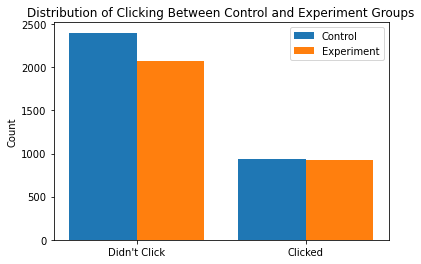

In [29]:
fig, ax = plt.subplots()

ax.hist(
    x=[control['click'], experiment['click']],
    label=["Control", "Experiment"],
    bins=[0,1,2],
    align="left"
)

ax.set_ylabel("Count")
ax.set_xticks([0,1])
ax.set_xticklabels(["Didn't Click", "Clicked"])
ax.set_title("Distribution of Clicking Between Control and Experiment Groups")

ax.legend();

In [56]:
ctrl_click_rate = sum(control['click'])/len(control)
exp_click_rate = sum(experiment['click'])/len(experiment)
print("Number of control samples: {} \t Number of experiment samples: {}".format(len(control), len(experiment)))
print("Number of control clicks: {} \t Number of experiment clicks: {}".format(sum(control['click']), sum(experiment['click'])))
print("Control click rate: {c: .4f} \t\t Experiment click rate: {e: .4f}".format(c = ctrl_click_rate, e = exp_click_rate))

Number of control samples: 3332 	 Number of experiment samples: 2996
Number of control clicks: 932.0 	 Number of experiment clicks: 928.0
Control click rate:  0.2797 		 Experiment click rate:  0.3097


In [34]:
contingency_table = pd.DataFrame()
contingency_table['Control'] = [len(control)-sum(control['click']), sum(control['click'])]
contingency_table['Experiment'] = [len(experiment)-sum(experiment['click']), sum(experiment['click'])]
contingency_table.index=["Didn't Click", "Clicked"]

In [35]:
contingency_table

,Control,Experiment
Didn't Click,2400.0,2068.0
Clicked,932.0,928.0


In [59]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("chi p-value: {}".format(p))

chi p-value: 0.009571680497042266


In [58]:
ttest_pvalue = stats.ttest_ind(control['click'], experiment['click'], equal_var=False).pvalue / 2
print("t-test p-value: {}".format(ttest_pvalue))

t-test p-value: 0.004466402814337101


Using either the chi squared test or a t-test, the pvalue is much lower than 0.05 and thus it would be 
reasonable to reject the null hypothesis that the experiment made no difference on click through rate.

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [38]:
#Your code here
expect_clicks = ctrl_click_rate * len(experiment)
expect_clicks

838.0168067226891

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [44]:
#Your code here
diff_clicks = sum(experiment['click']) - expect_clicks
var = len(experiment)*ctrl_click_rate*(1-ctrl_click_rate)
std = np.sqrt(var)
std

24.568547907005815

In [46]:
zval = diff_clicks/std
zval

3.6625360854823588

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [47]:
#Your code here
pval = 1 - stats.norm.cdf(zval)
pval

0.00012486528006949715

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: Yes, this is also far below a normal alpha of 0.05 and thus the null hypothesis would be rejected

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.